### Machine Learning Model on Cority (Accident/Incident)

In this notebook we do feature engineering to extract features from data then we run various machine learning models.

In [1]:
#Importing Packages
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.dates as mdates

import seaborn as sns

import random, re
import time

# used to supress display of warnings
import warnings

import missingno as mno

#### Loading Dataframe for feature engineering & ML

In [3]:
Inc_HK = pd.read_excel('Inc_HK_ready.xlsx')

In [4]:
Inc_HK.dtypes

Dayshift / Nightshift      int64
Entity                     int64
Year                       int64
Month                      int64
Day                        int64
WeekofYear                 int64
Season                     int64
Cleaned_Summary           object
line_length                int64
nb_words                   int64
Rating                     int64
Temp C                   float64
Rain mm                  float64
Weekday_number             int64
Project_type              object
Risk_type                 object
dtype: object

### Changes made to variables

<br> weekday_number {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
<br> Entity ('VSL','1')('Intrafor','2')(['Corp', 'FT'],'3')
<br> Rating: Incident = 1, Accident = 2, Incident & HiPo/or Serious =3, Accident & HiPo =4, Accident & Serious =5
<br> Change Day/Night Shift report from Y/N to 1/0
<br> Added rain & temperature
<br> Narrowing down the options for Project Type, Risk Type

#### Importing Libararies for feature engineering & ML

In [5]:
#Libraries
# sampling methods
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# import zscore for scaling the data
from scipy.stats import zscore

from scipy.stats import randint as sp_randint

# save models
import pickle

# pre-processing methods
from sklearn.model_selection import train_test_split

# the classification models 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# feature selection methods
from sklearn.pipeline import Pipeline

# ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score

# pre-processing methods
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from keras.utils import np_utils


### Feature Engineering
Variable Creation - TFIDF - on Cleaned_Summary - description of the record.

#### Variable Creation - TFIDF Features

In [6]:
#Variable Creation - TFIDF Features

inc_tfidf_df = pd.DataFrame()
for i in [1,2]:
    vec_tfidf = TfidfVectorizer(max_features=10, norm='l2', stop_words='english', lowercase=True, use_idf=True, ngram_range=(i,i))
    X = vec_tfidf.fit_transform(Inc_HK['Cleaned_Summary']).toarray()
    tfs = pd.DataFrame(X, columns=["TFIDF_" + n for n in vec_tfidf.get_feature_names()])
    inc_tfidf_df = pd.concat([inc_tfidf_df.reset_index(drop=True), tfs.reset_index(drop=True)], axis=1)

inc_tfidf_df.head()

C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,TFIDF_car,TFIDF_crane,TFIDF_end,TFIDF_fell,TFIDF_finger,TFIDF_hand,TFIDF_ip,TFIDF_struck,TFIDF_time,TFIDF_worker,TFIDF_crane lorry,TFIDF_gloves worn,TFIDF_labour supply,TFIDF_lorry crane,TFIDF_lost balance,TFIDF_stop end,TFIDF_struck damaged,TFIDF_supply worker,TFIDF_worker claimed,TFIDF_worn time
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.763209,0.646152,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.598359,0.0,0.675907,0.00000,0.0,0.430252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.605330,0.0,0.613989,0.000000,0.0,0.000000,0.50655,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Considering only top 20 TFIDF features

#### Variable Creation - Label Encoding
encoding for Project Type & Risk Type variables

In [7]:
#Variable Creation - Label Encoding

# To replace white space everywhere in Direct Employer
Inc_HK['Project_type'] = Inc_HK['Project_type'].str.replace(' ', '_')
Inc_HK['Project_type'].value_counts()


Foundation              46
Plant_&_Store           44
PT                      35
Others                  21
Ground_Investigation    17
Heavy_Lifting            9
Name: Project_type, dtype: int64

In [8]:
# To replace white space everywhere in Risk Type
Inc_HK['Risk_type'] = Inc_HK['Risk_type'].str.replace('\n', '').str.replace(' ', '_')
Inc_HK['Risk_type'].value_counts().head()

Lifting_Operation                     32
Manual_Handling                       27
Vehicle_and_Mobile_Plant_Operation    26
Access                                25
Others                                18
Name: Risk_type, dtype: int64

In [9]:
# Create Cority DataFrame
inc_featenc_df = pd.DataFrame()

inc_featenc_df['Rating'] = LabelEncoder().fit_transform(Inc_HK['Rating']).astype(np.int8)

In [10]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(inc_featenc_df['Rating'])
#dummy_y

In [11]:
# Dummy variables encoding

projtype_dummies = pd.get_dummies(Inc_HK['Project_type'], columns=['Project_type'], prefix='ProjType', drop_first=True)
risktype_dummies = pd.get_dummies(Inc_HK['Risk_type'], columns=['Risk_type'], prefix='RiskType', drop_first=True)
###specwork_dummies = pd.get_dummies(Inc_HK['Specific_work'], columns=['Specific_work'], prefix='SpecWork', drop_first=True)

# Merge the above dataframe with the original dataframe ind_feat_df
inc_featenc_df = inc_featenc_df.join(projtype_dummies.reset_index(drop=True)).join(risktype_dummies.reset_index(drop=True))

inc_featenc_df = Inc_HK[['Year','Month','Day','WeekofYear','Weekday_number']].reset_index(drop=True).join(inc_featenc_df.reset_index(drop=True))

inc_featenc_df.head()

,Year,Month,Day,WeekofYear,Weekday_number,Rating,ProjType_Ground_Investigation,ProjType_Heavy_Lifting,ProjType_Others,ProjType_PT,ProjType_Plant_&_Store,RiskType_Electrical_Safety,RiskType_Equipment_Operation,RiskType_Health,RiskType_Lifting_Operation,RiskType_Manual_Handling,RiskType_Others,RiskType_Use_of_Hand_Tools,RiskType_Vehicle_and_Mobile_Plant_Operation,RiskType_Working_at_Height
0,2019,1,2,1,2,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,2019,1,4,1,4,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,2019,3,4,10,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,2019,3,9,10,5,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2019,3,11,11,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [12]:
# Check NaN values
np.any(np.isnan(inc_featenc_df))

False

#### Combine TFIDF and Encoded Features

In [13]:
#Combine TFIDF and Encoded Features
# Consider only top 20 TFIDF features
inc_feat_df = inc_featenc_df.join(inc_tfidf_df.reset_index(drop=True))

In [14]:
inc_feat_df.head()

,Year,Month,Day,WeekofYear,Weekday_number,Rating,ProjType_Ground_Investigation,ProjType_Heavy_Lifting,ProjType_Others,ProjType_PT,...,TFIDF_crane lorry,TFIDF_gloves worn,TFIDF_labour supply,TFIDF_lorry crane,TFIDF_lost balance,TFIDF_stop end,TFIDF_struck damaged,TFIDF_supply worker,TFIDF_worker claimed,TFIDF_worn time
0,2019,1,2,1,2,2,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019,1,4,1,4,2,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,3,4,10,0,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,3,9,10,5,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019,3,11,11,0,2,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sampling Techniques - Create Training and Test Set

In [15]:
X = inc_feat_df.drop(['Rating'], axis = 1) # Considering all Predictors
y = inc_feat_df['Rating']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1, stratify = y)

In [17]:
X_train, X_test, y_train_dummy, y_test_dummy = train_test_split(X, dummy_y, test_size = 0.20, random_state = 1, stratify = y)

In [18]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (137,39)
y_train shape : (137,)
X_test shape : (35,39)
y_test shape : (35,)


#### Resampling Techniques — Oversample minority class

In [19]:
# Display old accident level counts
inc_feat_df['Rating'].value_counts()

1    87
0    45
2    23
3    13
4     4
Name: Rating, dtype: int64

The majory of the records falls under Accident rating 1

In [20]:

# Concatenate our training data back together
X_up = pd.concat([X_train, y_train], axis=1)

# Get the majority and minority class
acclevel_1_majority = X_up[X_up['Rating'] == 1]
acclevel_0_minority = X_up[X_up['Rating'] == 0]
acclevel_2_minority = X_up[X_up['Rating'] == 2]
acclevel_3_minority = X_up[X_up['Rating'] == 3]
acclevel_4_minority = X_up[X_up['Rating'] == 4]

# Upsample Level0 minority class
acclevel_0_minority_upsampled = resample(acclevel_0_minority,
                                replace = True, # sample with replacement
                                n_samples = len(acclevel_1_majority), # to match majority class
                                random_state = 1)

# Upsample Level2 minority class
acclevel_2_minority_upsampled = resample(acclevel_2_minority,
                                replace = True, # sample with replacement
                                n_samples = len(acclevel_1_majority), # to match majority class
                                random_state = 1)

# Upsample Level3 minority class
acclevel_3_minority_upsampled = resample(acclevel_3_minority,
                                replace = True, # sample with replacement
                                n_samples = len(acclevel_1_majority), # to match majority class
                                random_state = 1)

# Upsample Level4 minority class
acclevel_4_minority_upsampled = resample(acclevel_4_minority,
                                replace = True, # sample with replacement
                                n_samples = len(acclevel_1_majority), # to match majority class
                                random_state = 1)

In [21]:
# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([acclevel_1_majority, acclevel_0_minority_upsampled, acclevel_2_minority_upsampled, acclevel_3_minority_upsampled, 
                          acclevel_4_minority_upsampled])

In [22]:
# Display new accident level counts
df_upsampled['Rating'].value_counts()

1    69
0    69
2    69
3    69
4    69
Name: Rating, dtype: int64

Rating classes are balanced for training & testing models.

In [23]:
# Separate input features and target
X_train_up = df_upsampled.drop(['Rating'], axis = 1) # Considering all Predictors
y_train_up = df_upsampled['Rating']

#### Varible Tansformation (Normalization and Scaling)

In [24]:
# Transform independent features
scaler_X = StandardScaler()#StandardScaler()
pipeline = Pipeline(steps=[('s', scaler_X)])
X_train.iloc[:,:6] = pipeline.fit_transform(X_train.iloc[:,:6]) # Scaling only first 6 feautres

X_test.iloc[:,:6] = pipeline.fit_transform(X_test.iloc[:,:6]) # Scaling only first 6 feautres

In [25]:
X_train.head(3)

,Year,Month,Day,WeekofYear,Weekday_number,ProjType_Ground_Investigation,ProjType_Heavy_Lifting,ProjType_Others,ProjType_PT,ProjType_Plant_&_Store,...,TFIDF_crane lorry,TFIDF_gloves worn,TFIDF_labour supply,TFIDF_lorry crane,TFIDF_lost balance,TFIDF_stop end,TFIDF_struck damaged,TFIDF_supply worker,TFIDF_worker claimed,TFIDF_worn time
13,-1.405933,-0.623046,1.157063,-0.535480,1.288348,-0.337374,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23,-1.405933,1.024779,-0.605549,0.967815,0.171236,-0.337374,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-1.405933,-1.282176,0.452018,-1.211963,-0.945876,2.964071,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 10. Design, train and test machine learning classifiers

Here we can use the DummyClassifier to predict all accident levels just to show how misleading accuracy can be

In [26]:
# DummyClassifier to predict all Accident levels
dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0 1 2 3 4]
Test score:  0.42857142857142855


In [27]:
# Checking unique values
predictions = pd.DataFrame(dummy_pred)
predictions[0].value_counts()

1    16
0    11
2     4
3     3
4     1
Name: 0, dtype: int64

### Train and test model

Here we run various ML algorithims on the original data & the upsampling data & compare the models & see which ones give better results.

In [28]:
def train_test_model(model, method, X_train, X_test, y_train, y_test, of_type, index, report, save_model):
    
    if report == "yes":
        print (model)
        print ("***************************************************************************")

    if method == 'CatBoostClassifier' or method == 'LGBMClassifier':

      model.fit(X_train, y_train) # Fit the model on Training set
    else:
      model.fit(X_train, y_train) # Fit the model on Training set

    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
    
    if of_type == "coef":
        # Intercept and Coefficients
        print("The intercept for our model is {}".format(model.intercept_), "\n")
        
        for idx, col_name in enumerate(X_train.columns):
            print("The coefficient for {} is {}".format(col_name, model.coef_.ravel()[idx]))

    y_pred = model.predict(X_test) # Predict on Test set

    # Initialise mc_logloss
    mc_logloss = 1.00
    if method != 'RidgeClassifier':
      y_predictions = model.predict_proba(X_test)

    train_accuracy_score = model.score(X_train, y_train)
    test_accuracy_score = model.score(X_test, y_test)

    precision_score = precision_score(y_test, y_pred, average='weighted')
    recall_score = recall_score(y_test, y_pred, average='weighted')
    f1_score = f1_score(y_test, y_pred, average='weighted')


    if report == "yes":
      # Model - Confusion matrix
      model_cm = confusion_matrix(y_test, y_pred)

      sns.heatmap(model_cm, annot=True,  fmt='.2f', xticklabels = ["I", "II", "III", "IV", "V"] , yticklabels = ["I", "II", "III", "IV", "V"] )
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.show()

      # Model - Classification report
      model_cr = classification_report(y_test, y_pred)
      print(model_cr)

    # Store the accuracy results for each model in a dataframe for final comparison
    resultsDf = pd.DataFrame({'Method': method, 'Train Accuracy': train_accuracy_score, 'Test Accuracy': test_accuracy_score, 
                              'Precision': precision_score, 'Recall': recall_score, 'F1-Score': f1_score, 
                              }, index=[index])
    
    # Save the model
    if save_model == "yes":
      filename = 'finalised_model.sav'
      pickle.dump(model, open(filename, 'wb'))
      
    return resultsDf  # return all the metrics along with predictions

In [29]:
import lightgbm as lgb

def train_test_allmodels(X_train_common, X_test_common, y_train, y_test):

    # define classification models
    models=[['LogisticRegression',LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state = 1)],
        ['LogisticRegression-ovr',LogisticRegression(solver='lbfgs', multi_class='ovr', random_state = 1)],
        ['RidgeClassifier',RidgeClassifier(random_state = 1)],
        #['Lasso',Lasso(random_state = 1)],
        ['KNeighborsClassifier',KNeighborsClassifier(n_neighbors = 3)],
        ['SVC',SVC(kernel = 'rbf', probability=True)],
        ['DecisionTreeClassifier',DecisionTreeClassifier(criterion = 'gini', random_state=1)],
        ['RandomForestClassifier',RandomForestClassifier(n_estimators=10, random_state=1)],
        ['BaggingClassifier',BaggingClassifier(n_estimators=30, max_samples=0.75, random_state=1, oob_score=True)],
        ['ExtraTreesClassifier',ExtraTreesClassifier(n_estimators = 50, criterion='entropy', max_features='auto', min_samples_split=2, 
                                 bootstrap=True, oob_score=True)],
        ['AdaBoostClassifier',AdaBoostClassifier(n_estimators=100, learning_rate=0.25, random_state=1)],
        ['GradientBoostingClassifier',GradientBoostingClassifier(loss='deviance', n_estimators=50, learning_rate=0.1, validation_fraction=0.2, 
                                       random_state=1)],
        ['CatBoostClassifier',CatBoostClassifier(task_type= 'GPU', loss_function="MultiClass", random_state=1, verbose=0)],
                                                #early_stopping_rounds = 30)],
        ['LGBMClassifier',LGBMClassifier(random_state=1, metric = "multi_logloss", objective="multiclass")],
                                         #early_stopping_rounds = 30)],
        ['XGBClassifier',XGBClassifier(min_child_weight = 7, max_depth = 6, objective="multi:softproba", learning_rate = 0.1, gamma = 0.4, 
                                       colsample_bytree = 0.5)]
    ]

    resultsDf_common = pd.DataFrame()
    i = 1
    for name, classifier in models:
        # Train and Test the model
        reg_resultsDf = train_test_model(classifier, name, X_train_common, X_test_common, y_train, y_test, 'none', i, 'no', 'no')

        # Store the accuracy results for each model in a dataframe for final comparison
        resultsDf_common = pd.concat([resultsDf_common, reg_resultsDf])
        i = i+1

    return resultsDf_common

#### All models - Original data

In [44]:
# Train and Test all models with Lasso interaction terms
train_test_allmodels(X_train, X_test, y_train, y_test)

C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334

,Method,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
1,LogisticRegression,0.839416,0.542857,0.444857,0.542857,0.479776
2,LogisticRegression-ovr,0.817518,0.514286,0.412315,0.514286,0.429273
3,RidgeClassifier,0.875912,0.542857,0.485714,0.542857,0.512088
4,KNeighborsClassifier,0.744526,0.542857,0.608571,0.542857,0.536341
5,SVC,0.751825,0.628571,0.514286,0.628571,0.532653
6,DecisionTreeClassifier,1.000000,0.371429,0.348980,0.371429,0.353818
7,RandomForestClassifier,0.963504,0.542857,0.416883,0.542857,0.471429
8,BaggingClassifier,0.985401,0.457143,0.371180,0.457143,0.409316
9,ExtraTreesClassifier,0.992701,0.542857,0.433333,0.542857,0.468571
10,AdaBoostClassifier,0.532847,0.514286,0.396735,0.514286,0.431233


Best F1 score 64% by XGBClassifier

#### All models - Oversampling data

In [45]:
# Train and Test all models with Lasso interaction terms
train_test_allmodels(X_train_up, X_test, y_train_up, y_test)

C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

,Method,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
1,LogisticRegression,0.547826,0.428571,0.822222,0.428571,0.503302
2,LogisticRegression-ovr,0.776812,0.371429,0.633694,0.371429,0.400819
3,RidgeClassifier,0.863768,0.057143,0.003265,0.057143,0.006178
4,KNeighborsClassifier,0.892754,0.142857,0.020408,0.142857,0.035714
5,SVC,0.371014,0.142857,0.020408,0.142857,0.035714
6,DecisionTreeClassifier,1.000000,0.457143,0.458671,0.457143,0.428192
7,RandomForestClassifier,1.000000,0.542857,0.583810,0.542857,0.521872
8,BaggingClassifier,0.997101,0.542857,0.539973,0.542857,0.520540
9,ExtraTreesClassifier,1.000000,0.485714,0.483203,0.485714,0.476623
10,AdaBoostClassifier,0.353623,0.228571,0.315238,0.228571,0.197421


By comparing the results from all above methods, we can select best method as Logistic Regression with f1-score 50% and all other methods are over fitting the training data.

<br>Note that one of the reasons the results may not seem as good, is due to having many variables around 30-40 but not having enough observations / data to train & test the models. We will have to take narrow down the variables and try select the ones that have the most impact / significant.

We take a closer look at the Logistic Regression, Random Forest & Gradient Booting on both Original & Upsampling data and see which variables are more significant.

#### 1. Modelling - Logistic Regression

Looking into the variables with highest coeffiecent (most significant)

In [30]:
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state = 1)
logreg.fit(X_train, y_train)
log_odds = logreg.coef_[0]
pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
RiskType_Health,1.251027
RiskType_Vehicle_and_Mobile_Plant_Operation,1.152153
RiskType_Others,1.036989
TFIDF_car,0.895795
RiskType_Electrical_Safety,0.712144
TFIDF_struck damaged,0.705545
TFIDF_stop end,0.539500
TFIDF_end,0.503626
TFIDF_lorry crane,0.427410
ProjType_Others,0.219930


In [31]:
odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
RiskType_Health,3.493928
RiskType_Vehicle_and_Mobile_Plant_Operation,3.164998
RiskType_Others,2.820710
TFIDF_car,2.449282
RiskType_Electrical_Safety,2.038357
TFIDF_struck damaged,2.024949
TFIDF_stop end,1.715149
TFIDF_end,1.654710
TFIDF_lorry crane,1.533281
ProjType_Others,1.245989


Risk_type & TFIDF Health & Vehicles have the highest impact using Logestic Regression

LogisticRegression(multi_class='multinomial', random_state=1)
***************************************************************************


C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


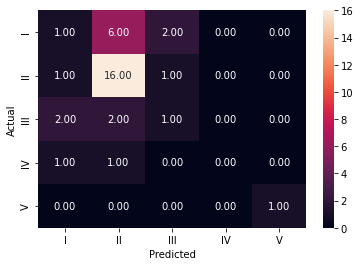

              precision    recall  f1-score   support

           0       0.20      0.11      0.14         9
           1       0.64      0.89      0.74        18
           2       0.25      0.20      0.22         5
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         1

    accuracy                           0.54        35
   macro avg       0.42      0.44      0.42        35
weighted avg       0.44      0.54      0.48        35



C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Method,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
1,Logistic Regression without Sampling,0.839416,0.542857,0.444857,0.542857,0.479776


In [32]:
# For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs' handle multinomial loss; 'liblinear' is limited to one-versus-rest schemes.

resultsDf = pd.DataFrame()

# Building a Linear Regression model
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state = 1)
                                                     
# Train and Test the model
resultsDf = train_test_model(lr, 'Logistic Regression without Sampling', X_train, X_test, y_train, y_test, 'none', 1, 'yes', 'no')

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf

Linear Regression model with multi_class: 'ovr' 

LogisticRegression(multi_class='ovr', random_state=1)
***************************************************************************


C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


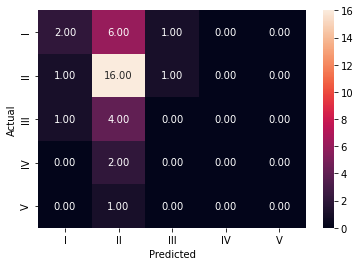

              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.55      0.89      0.68        18
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1

    accuracy                           0.51        35
   macro avg       0.21      0.22      0.20        35
weighted avg       0.41      0.51      0.43        35



C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Method,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
1,Logistic Regression without Sampling,0.817518,0.514286,0.412315,0.514286,0.429273


In [33]:
resultsDf1 = pd.DataFrame()

# Building a Linear Regression model
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state = 1)
                                                     
# Train and Test the model
resultsDf1 = train_test_model(lr, 'Logistic Regression without Sampling', X_train, X_test, y_train, y_test, 'none', 1, 'yes', 'no')

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf1

Linear Regression model with multi_class: 'multinomial' shows better results.

#### 2. Decision Tree - Random Forest Classifier

While in every machine learning problem, it’s a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets. Decision trees frequently perform well on imbalanced data. They work by learning a hierarchy of if/else questions and this can force both classes to be addressed.

RandomForestClassifier(n_estimators=10, random_state=1)
***************************************************************************


C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


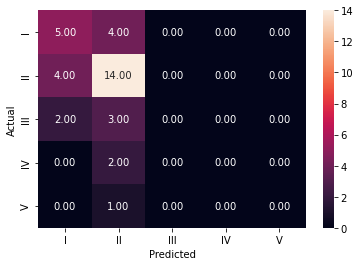

              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.58      0.78      0.67        18
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1

    accuracy                           0.54        35
   macro avg       0.21      0.27      0.23        35
weighted avg       0.42      0.54      0.47        35



C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Method,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
1,Logistic Regression without Sampling,0.839416,0.542857,0.444857,0.542857,0.479776
2,Random Forest with original data,0.963504,0.542857,0.416883,0.542857,0.471429


In [34]:
# Building a Random Forest Classifier on Training set
rfc_model = RandomForestClassifier(n_estimators=10, random_state=1)

# Train and Test the model
rf_df = train_test_model(rfc_model, 'Random Forest with original data', X_train, X_test, y_train, y_test, 'none', 2, 'yes', 'no')

#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.concat([resultsDf,rf_df])
resultsDf

#### Dsiplay Important variables on Decision tress & random forest

In [35]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]

In [36]:
rfc_model = RandomForestClassifier(n_estimators=10, random_state=1)
rfc_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [37]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)

Text(0.5, 0, 'Random Forest Feature Importance')

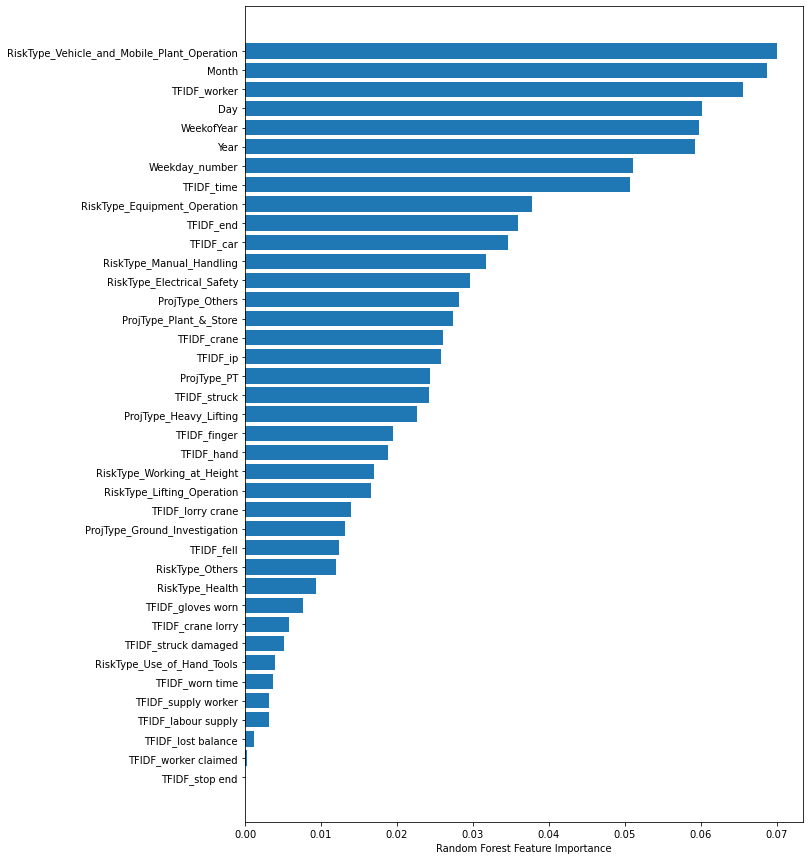

In [38]:
sorted_idx = rfc_model.feature_importances_.argsort()
fig = plt.figure(figsize=(10,15))
plt.barh(X_train.columns[sorted_idx], rfc_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Risk_Type Vehicle & Calendar (Month, Day & Year..) are most important

Creating permutation importance function to display the variables with most importance on Random Forest model

In [39]:
def print_permutation_importances(df_X, mymodel, ar_Xtrain, ar_yTrain, repeats = 10, numjobs=-1):
    
    p_importances = permutation_importance(mymodel, ar_Xtrain, ar_yTrain, n_repeats=repeats, n_jobs=-1)
            
    sorted_idx = p_importances.importances_mean.argsort()
    plt.figure(figsize=(10, 20))
    plt.barh(list(df_X.columns[sorted_idx]),
        p_importances.importances_mean[sorted_idx],
        yerr=p_importances.importances_std[sorted_idx], )
    plt.ylabel('feature')
    plt.xlabel('importance')
    plt.xlim(0, 1);

    for i in p_importances.importances_mean.argsort()[::-1]:
        if p_importances.importances_mean[i] - 2 * p_importances.importances_std[i] > 0:
            print(f"{df_X.columns[i]:<45}"
              f"{p_importances.importances_mean[i]:.3f}"
              f" +/- {p_importances.importances_std[i]:.3f}")

RiskType_Vehicle_and_Mobile_Plant_Operation  0.093 +/- 0.030
TFIDF_worker                                 0.082 +/- 0.019
RiskType_Equipment_Operation                 0.043 +/- 0.009
WeekofYear                                   0.043 +/- 0.020
TFIDF_end                                    0.039 +/- 0.009
TFIDF_time                                   0.036 +/- 0.006
Weekday_number                               0.035 +/- 0.015
Month                                        0.028 +/- 0.007
Year                                         0.025 +/- 0.011
ProjType_Heavy_Lifting                       0.023 +/- 0.004
ProjType_Others                              0.018 +/- 0.005
RiskType_Manual_Handling                     0.016 +/- 0.005
RiskType_Electrical_Safety                   0.015 +/- 0.007
TFIDF_hand                                   0.015 +/- 0.007
RiskType_Working_at_Height                   0.014 +/- 0.002
RiskType_Others                              0.009 +/- 0.003
RiskType_Lifting_Operati

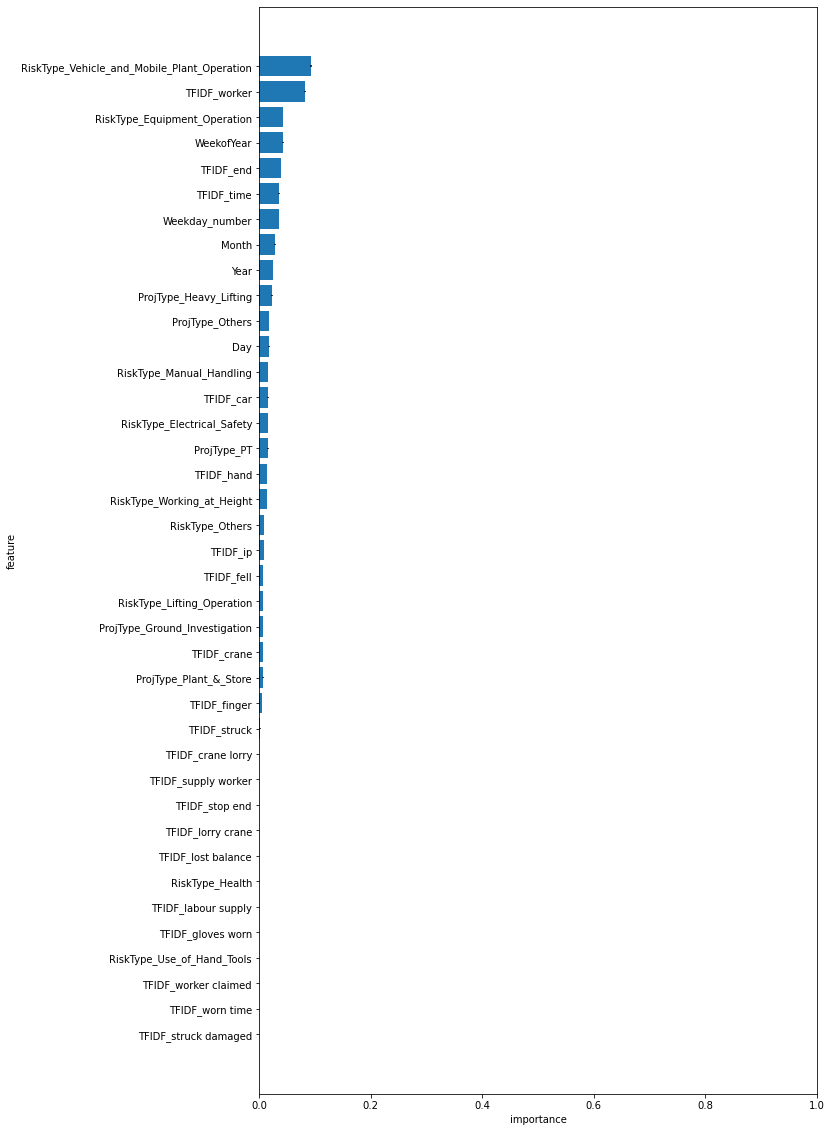

In [40]:
from sklearn.inspection import permutation_importance
print_permutation_importances(X_train, rfc_model, X_train, y_train)

Risk_Type Vehicle still showing to be the most important variable

#### 3. GradientBoostingClassifier

In [42]:
modelgb=GradientBoostingClassifier(loss='deviance', n_estimators=50, learning_rate=0.1, validation_fraction=0.2, 
                                       random_state=1)
modelgb.fit(X_train, y_train) 

C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(loss='deviance', n_estimators=50, random_state=1,
                           validation_fraction=0.2)

TFIDF_worker                                 0.100 +/- 0.014
RiskType_Equipment_Operation                 0.081 +/- 0.008
WeekofYear                                   0.078 +/- 0.014
ProjType_Plant_&_Store                       0.059 +/- 0.016
Day                                          0.047 +/- 0.010
TFIDF_time                                   0.046 +/- 0.010
Year                                         0.039 +/- 0.005
RiskType_Electrical_Safety                   0.036 +/- 0.007
RiskType_Vehicle_and_Mobile_Plant_Operation  0.030 +/- 0.008
RiskType_Health                              0.028 +/- 0.007
ProjType_Heavy_Lifting                       0.024 +/- 0.005
RiskType_Others                              0.023 +/- 0.005
TFIDF_end                                    0.019 +/- 0.004
RiskType_Working_at_Height                   0.018 +/- 0.005
ProjType_Others                              0.013 +/- 0.004
TFIDF_car                                    0.012 +/- 0.005
TFIDF_hand              

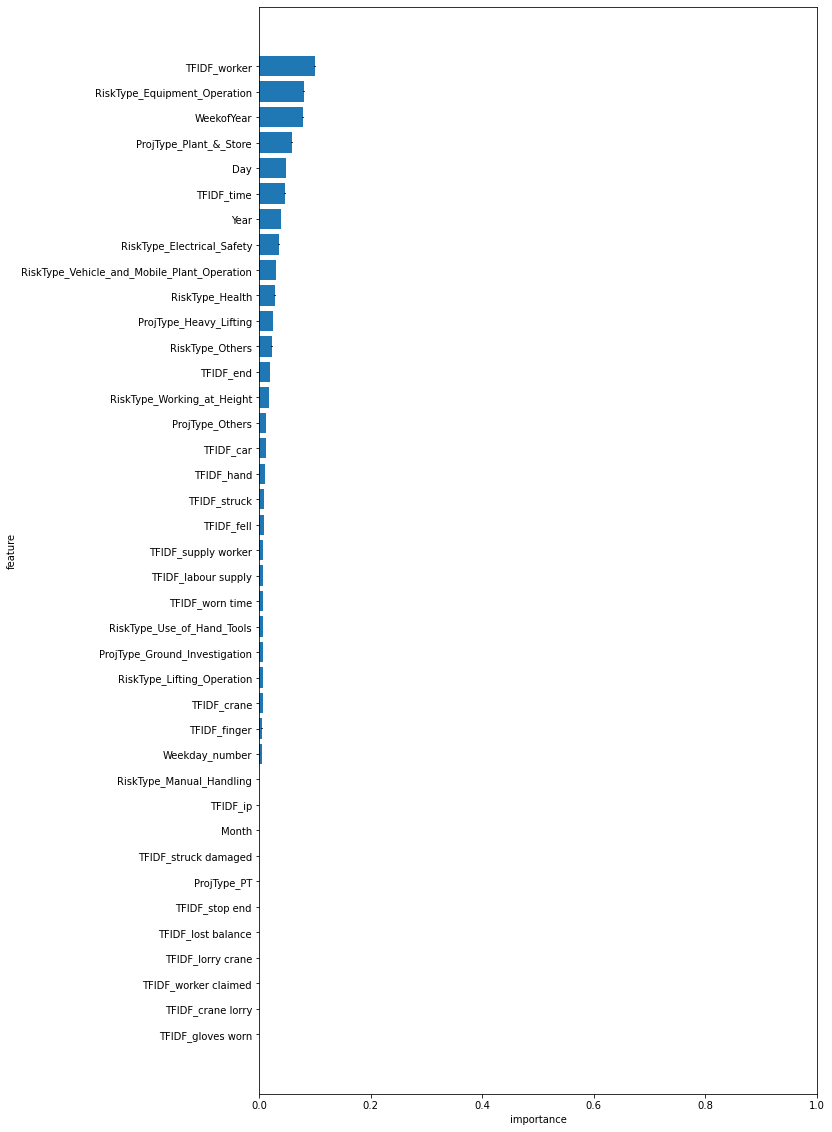

In [43]:
print_permutation_importances(X_train, modelgb, X_train, y_train) 

### Oversampling
#### 4. Modelling - Logistic Regression

LogisticRegression(multi_class='multinomial', random_state=1)
***************************************************************************


C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


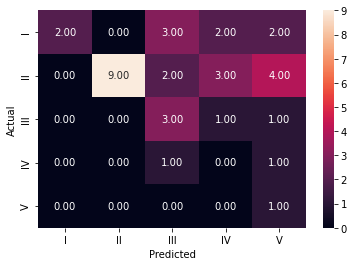

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       1.00      0.50      0.67        18
           2       0.33      0.60      0.43         5
           3       0.00      0.00      0.00         2
           4       0.11      1.00      0.20         1

    accuracy                           0.43        35
   macro avg       0.49      0.46      0.33        35
weighted avg       0.82      0.43      0.50        35



,Method,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
1,Logistic Regression without Sampling,0.839416,0.542857,0.444857,0.542857,0.479776
2,Random Forest with original data,0.963504,0.542857,0.416883,0.542857,0.471429
3,Logistic Regression with Sampling,0.547826,0.428571,0.822222,0.428571,0.503302


In [41]:
# Building a Linear Regression model
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state = 1)
                                                     
# Train and Test the model
lr_df = train_test_model(lr, 'Logistic Regression with Sampling', X_train_up, X_test, y_train_up, y_test, 'none', 3, 'yes', 'no')

#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.concat([resultsDf,lr_df])
resultsDf

#### 5. GradientBoostingClassifier - OverSampling

In [46]:
modelgb=GradientBoostingClassifier(loss='deviance', n_estimators=50, learning_rate=0.1, validation_fraction=0.2, 
                                       random_state=1)
modelgb.fit(X_train_up, y_train_up)

C:\Users\ho.fahmy\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(loss='deviance', n_estimators=50, random_state=1,
                           validation_fraction=0.2)

WeekofYear                                   0.215 +/- 0.016
Year                                         0.190 +/- 0.016
Day                                          0.114 +/- 0.014
RiskType_Equipment_Operation                 0.063 +/- 0.005
TFIDF_worker                                 0.046 +/- 0.007
TFIDF_crane                                  0.043 +/- 0.004
TFIDF_time                                   0.034 +/- 0.005
RiskType_Health                              0.028 +/- 0.003
ProjType_Heavy_Lifting                       0.025 +/- 0.004
RiskType_Vehicle_and_Mobile_Plant_Operation  0.020 +/- 0.005
RiskType_Others                              0.019 +/- 0.001
TFIDF_worn time                              0.017 +/- 0.002
TFIDF_end                                    0.015 +/- 0.002
ProjType_Plant_&_Store                       0.015 +/- 0.003
RiskType_Use_of_Hand_Tools                   0.012 +/- 0.001
TFIDF_car                                    0.011 +/- 0.003
RiskType_Manual_Handling

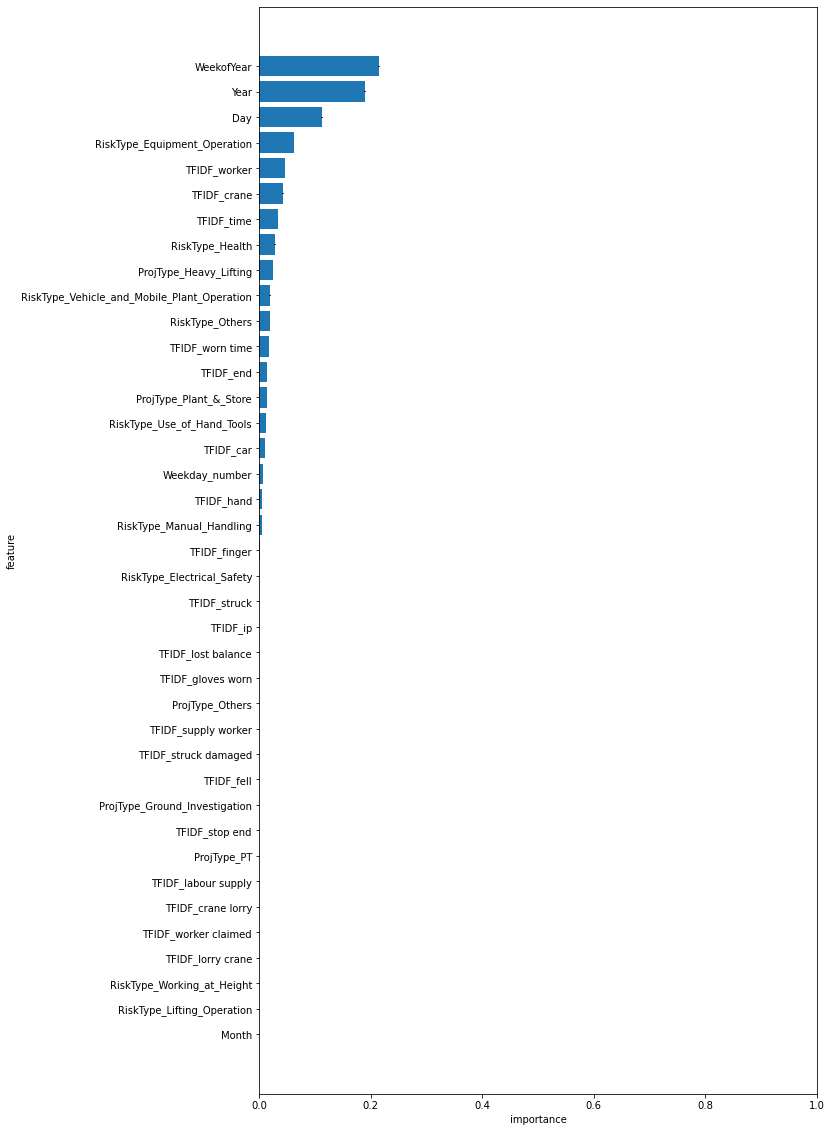

In [47]:
print_permutation_importances(X_train, modelgb, X_train_up, y_train_up) 